In [1]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
import matplotlib.pyplot as plt

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader as TimeSeriesLoaderGeneral

from nixtla.models.esrnn.esrnn import ESRNN

In [2]:
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-365 * 24:] = 0
sum(train_outsample_mask)
epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_train_mask=train_outsample_mask)
# print('X: time series features, of shape (#series,#times,#features): \t' + str(X.shape))
# print('Y: target series (in X), of shape (#series,#times): \t \t' + str(Y.shape))
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
Y_df.head()

Processing dataframes ...
Creating ts tensor ...


,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


In [3]:
train_loader = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
                                    model='esrnn',
                                    offset=24,
                                    window_sampling_limit= 90*1*24, #365*4*24
                                    input_size=7*24,
                                    output_size=24,
                                    idx_to_sample_freq=1,
                                    batch_size=1,
                                    is_train_loader=True)

In [12]:
esrnn = ESRNN(input_size=7*24,
              output_size=24,
              max_epochs=50,
              freq_of_test=-1,
              learning_rate=1e-3,
              lr_scheduler_step_size=9,
              lr_decay=0.9,
              per_series_lr_multip=1.0,
              gradient_eps=1e-8,
              gradient_clipping_threshold=20,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=200,
              testing_percentile=50,
              training_percentile=50,
              cell_type='LSTM',
              state_hsize=40,
              dilations=[[1, 2], [4, 8]],
              add_nl_layer=False,
              seasonality=[24],
              frequency=None,
              max_periods=20,
              random_seed=1,
              device='cpu')

In [13]:
esrnn.fit(train_ts_loader=train_loader, eval_epochs=1)

Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 3.759, Insample loss: 0.14862
Epoch: 1, Time: 7.687, Insample loss: 0.14558
Epoch: 2, Time: 11.587, Insample loss: 0.14277
Epoch: 3, Time: 15.512, Insample loss: 0.14014
Epoch: 4, Time: 19.384, Insample loss: 0.13768
Epoch: 5, Time: 23.325, Insample loss: 0.13536
Epoch: 6, Time: 27.327, Insample loss: 0.13316
Epoch: 7, Time: 31.440, Insample loss: 0.13106
Epoch: 8, Time: 35.535, Insample loss: 0.12907
Epoch: 9, Time: 39.529, Insample loss: 0.12723
Epoch: 10, Time: 43.517, Insample loss: 0.12573
Epoch: 11, Time: 47.506, Insample loss: 0.12437
Epoch: 12, Time: 51.518, Insample loss: 0.12313
Epoch: 13, Time: 55.583, Insample loss: 0.12202
Epoch: 14, Time: 59.527, Insample loss: 0.12109
Epoch: 15, Time: 63.507, Insample loss: 0.12034
Epoch: 16, Time: 67.462, Insample loss: 0.11975
Epoch: 17, Time: 71.387, Insample loss: 0.11927
Epoch: 18, Time: 75.385, Insample loss: 0.11886
Epoch: 19, Time: 79.365, Insam

In [14]:
y_hat = esrnn.predict(ts_loader=train_loader)

forecast shape torch.Size([1, 24])
forecasts shape (1, 24)


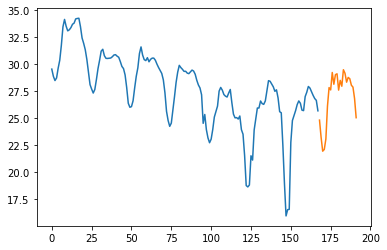

In [15]:
y_plot = Y_df['y'][-168:]
y_hat_plot = y_hat['y_hat']
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot)